# DES Simulation

This notebook generates the results used in the report for the second assignment of the course 'Stochastic Simulation'.

Authors:

1. Divyaben Hasmukhbhai Gajera
- Affiliation: MSc Computational Science, University of Amsterdam
- Email: divya.gajera@student.uva.nl
- Student Number: 14932644

2. K. López
- Affiliation: MSc Computational Science, University of Amsterdam
- Email: kenia.lopez.sotomayor@student.uva.nl
- Student Number: 12965081

3. T. P. Glansdorp
- Affiliation: MSc Computational Science, University of Amsterdam
- Email: thomas.glansdorp@student.uva.nl
- Student Number: 12748587

In [34]:
import simpy as sp
import numpy as np
import matplotlib.pyplot as plt
import random
import queue

## DES program that implements FIFO scheduling case

In [96]:
class MMnFIFOQueue:
    def __init__(self, env, arrival_rate, service_rate, n):
        self.env = env
        self.server = sp.Resource(env, capacity=n)
        self.arrival_rate = arrival_rate
        self.service_rate = service_rate
        self.queue = []

        env.process(self.arrive())
        

    def arrive(self):
        customer_count = 0
        while True:
            inter_arrival_time = random.expovariate(self.arrival_rate)
            yield self.env.timeout(inter_arrival_time)
            self.queue.append(self.env.now)
            customer_count += 1
            self.env.process(self.depart(customer_count))
            print(f"Customer {customer_count} arrived at {self.env.now}")

            
    def depart(self, customer_count):
        print(self.queue)
        with self.server.request() as request:
            yield request
            service_time = random.expovariate(self.service_rate)
            yield self.env.timeout(service_time)
            self.queue.pop(0)
            print(f"Customer {customer_count} departed at {self.env.now} with wait_time of {service_time}")


def run_MMn_FIFO_queue(arrival_rate, service_rate, n, simulation_time):
    env = sp.Environment()
    mmn_queue = MMnFIFOQueue(env, arrival_rate, service_rate, n)
    env.run(until=simulation_time)


In [80]:
arrival_rate = 2.0
service_rate = 3.0
simulation_time = 10.0
n = 2

run_MMn_FIFO_queue(arrival_rate, service_rate, n, simulation_time)

NameError: name 'run_MMn_FIFO_queue' is not defined

In [82]:
import simpy as sm
import random
import pandas as pd
import csv
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt

In [122]:
class g:
    arrival_rate = 1
    service_rate = 2
    number_of_servers = 1
    sim_duration = 300
    number_of_runs = 10

class Customer:
    def __init__(self, customer_id):
        self.id = customer_id
        self.queue_time = 0

class Queue:
    
    def __init__(self, run_number, queue_type):
        self.env = sm.Environment()
        self.server = sm.Resource(self.env, capacity=g.number_of_servers)
        self.run_number = run_number
        self.queue_type = queue_type
        self.customer_counter = 0
        self.mean_queue_time = 0
        self.mean_system_time = 0
        self.mean_service_time = 0
        #self.file_name = file_name
        columns = ["Customer ID", "Start Queueing", "End Queueing", "Queueing Time", "Sojourn Time", "Service Time"] 
        self.results_df = pd.DataFrame(columns=columns)
        self.results_df.set_index("Customer ID", inplace=True)
        
    
    # Method that generates customers arrivals
    def generate_arrivals(self):
        while True:
            self.customer_counter += 1
            cp = Customer(self.customer_counter)
            # Run activity generator for this customer
            self.env.process(self.create_queue(cp))

            # sample time until next customer
            t = random.expovariate(g.arrival_rate)

            # Freeze untill that time has passed
            yield self.env.timeout(t)
            
    def create_queue(self, customer):
        start_queue = self.env.now
        
        # Request a server
        with self.server.request() as req:
            # Freeze until the request can be met 
            yield req
            
            # Sample time spent in server
            if self.queue_type == "MMn":
                sampled_service_time = random.expovariate(g.service_rate)
            elif self.queue_type == "MDn":
                sampled_service_time = 1/2
            
            end_queue = self.env.now
            
            # Freeze until that time has passed
            yield self.env.timeout(sampled_service_time)
            
            # Calculate time customer was queueing
            out_of_system = self.env.now
            sojourn_time = out_of_system - start_queue
            customer.queue_time = end_queue - start_queue
            df_to_add = pd.DataFrame({"Customer ID":[customer.id], "Start Queueing": [start_queue],
                                     "End Queueing": [end_queue], "Queueing Time": [customer.queue_time],
                                     "Sojourn Time": [sojourn_time], "Service Time":[sampled_service_time]})
            df_to_add.set_index("Customer ID", inplace=True)
            self.results_df = self.results_df.append(df_to_add)
            
    def calculate_mean_times(self):
        self.mean_queue_time = self.results_df["Queueing Time"].mean()
        self.mean_system_time = self.results_df["Sojourn Time"].mean()
        self.mean_service_time = self.results_df["Service Time"].mean()
        
    def write_run_results(self):
        with open(self.file_name, "a") as f:
            writer = csv.writer(f, delimiter=",")
            results_to_write = [self.run_number, self.mean_queue_time]
            writer.writerow(results_to_write)
            
    def run(self):
        self.env.process(self.generate_arrivals())
        self.env.run(until=g.sim_duration)
        # Calculate run results
        self.calculate_mean_times()
        #self.write_run_results()
        

In [84]:
def calculate_CI(data):
    
    sigma = data.std()
    x_bar = data.mean()
    CI = (x_bar - (1.96*sigma/np.sqrt(data.shape[0])), x_bar + (1.96*sigma/np.sqrt(data.shape[0])))
    
    return CI

In [95]:
def estimate_waiting_times(type_queue, RHO, MU, n):
    
    mean_queue = []
    mean_sojourn = []
    mean_service = []
    for rho in RHO:
        temp_mean_queue_run = []
        temp_sj = []
        temp_serice = []
        g.arrival_rate = MU*rho
        g.service_rate = MU
        g.number_of_servers = n
        g.number_of_runs = 100
        for run in range(g.number_of_runs):
            queue_model = Queue(run, type_queue)
            queue_model.run()
            temp_mean_queue_run.append(queue_model.mean_queue_time)
            temp_sj.append(queue_model.mean_system_time)
            temp_serice.append(queue_model.mean_service_time)
        mean_queue.append(np.array(temp_mean_queue_run).mean(axis=0))
        mean_sojourn.append(np.array(temp_sj).mean(axis = 0))
        mean_service.append(np.array(temp_serice).mean(axis=0))
    
    return mean_queue, mean_sojourn, mean_service

In [96]:
MU = 4
RHO = [0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
num_sim = [5, 10, 25, 50, 100, 150, 500, 1000]

In [97]:
est_mean, est_sojourn, est_service = estimate_waiting_times("MMn", RHO, MU, 1)

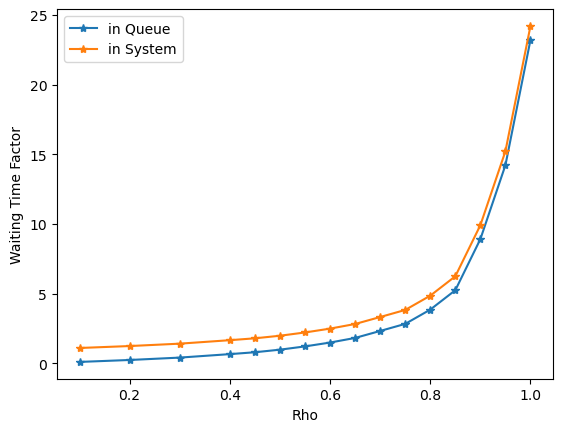

In [115]:
plt.plot(RHO, np.array(est_mean)/np.array(est_service),"*-", label= "in Queue")
plt.plot(RHO, np.array(est_sojourn)/np.array(est_service), "*-", label="in System")
plt.xlabel("Rho")
plt.ylabel("Waiting Time Factor")
plt.legend()
plt.show()

In [107]:
est_mean_2, est_sojourn_2, est_service_2 = estimate_waiting_times("MMn", RHO, MU, 2)
    

In [108]:
est_mean_4, est_sojourn_4, est_service_4 = estimate_waiting_times("MMn", RHO, MU, 4)

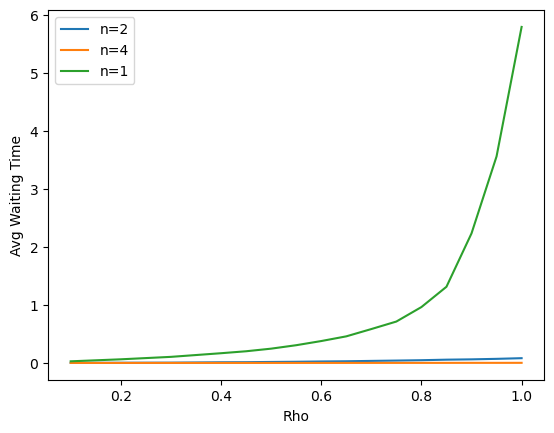

In [109]:
plt.plot(RHO, est_mean_2, label="n=2")
plt.plot(RHO, est_mean_4, label="n=4")
plt.plot(RHO, est_mean, label="n=1")
plt.legend()
plt.xlabel("Rho")
plt.ylabel("Avg Waiting Time")
plt.show()

In [123]:
est_mean_MDn_1, est_sojourn_MDn_1, est_service_MDn_1 = estimate_waiting_times("MDn", RHO, MU, 1)
est_mean_MDn_2, est_sojourn_MDn_2, est_service_MDn_2 = estimate_waiting_times("MDn", RHO, MU, 2)
est_mean_MDn_4, est_sojourn_MDn_4, est_service_MDn_4 = estimate_waiting_times("MDn", RHO, MU, 4)

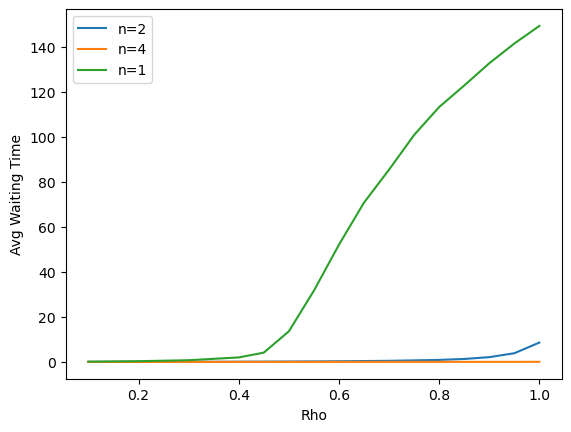

In [124]:
plt.plot(RHO, np.array(est_mean_MDn_2)/np.array(est_service_MDn_2), label="n=2")
plt.plot(RHO, np.array(est_mean_MDn_4)/np.array(est_service_MDn_4), label="n=4")
plt.plot(RHO, np.array(est_mean_MDn_1)/np.array(est_service_MDn_1), label="n=1")
plt.legend()
plt.xlabel("Rho")
plt.ylabel("Avg Waiting Time")
plt.show()

### Numer of measurements required

## DES program that implements shortest job first case for M/M/1

In [5]:
class SJF_queue:
    
    def __init__(self, run_number):
        self.env = sm.Environment()
        self.customer_counter = 0
        self.server = sm.PriorityResource(self.env, capacity=g.number_of_servers)
        self.run_number = run_number
        self.mean_queue_time = 0
        self.mean_system_time = 0
        self.mean_service_time = 0
        self.results_df = pd.DataFrame()
        columns = ["Customer ID", "Start Queueing", "End Queueing", "Queueing Time", "Sojourn Time", "Service Time"] 
        self.results_df = pd.DataFrame(columns=columns)
        self.results_df.set_index("Customer ID", inplace=True)
        
    
    # Method that generates customers arrivals
    def generate_arrivals(self):
        while True:
            self.customer_counter += 1
            cp = Customer(self.customer_counter)
            # Run activity generator for this customer
            self.env.process(self.create_queue(cp))

            # sample time until next customer
            t = random.expovariate(1.0/g.arrival_rate)

            # Freezr untill that time has passed
            yield self.env.timeout(t)
            
    def create_queue(self, customer):
        start_queue = self.env.now
        # Request a server
        sampled_service_time = random.expovariate(1.0/g.service_rate)
        with self.server.request(priority = int(sampled_service_time)) as req:
            # Freeze until the request can be met 
            yield req  
            
            end_queue = self.env.now

            # Freeze until that time has passed
            yield self.env.timeout(sampled_service_time)
            
            # Calculate time customer was queueing
            out_of_system = self.env.now
            sojourn_time = out_of_system - start_queue
            customer.queue_time = end_queue - start_queue
            df_to_add = pd.DataFrame({"Customer ID":[customer.id], "Start Queueing": [start_queue],
                                     "End Queueing": [end_queue], "Queueing Time": [customer.queue_time],
                                     "Sojourn Time": [sojourn_time], "Service Time":[sampled_service_time]})
            df_to_add.set_index("Customer ID", inplace=True)
            self.results_df = self.results_df.append(df_to_add)
            
    def calculate_mean_waiting_times(self):
        self.mean_queue_time = self.results_df["Queueing Time"].mean()
        self.mean_system_time = self.results_df["Sojourn Time"].mean()
        self.mean_service_time = self.results_df["Service Time"].mean()
        
    def write_run_results(self):
        with open("trial_results.csv", "a") as f:
            writer = csv.writer(f, delimiter=",")
            results_to_write = [self.run_number, self.mean_queue_time]
            writer.writerow(results_to_write)
            
    def run(self):
        self.env.process(self.generate_arrivals())
        self.env.run(until=g.sim_duration)
        # Calculate run results
        self.calculate_mean_queue_time()
        #self.write_run_results()
      


In [ ]:
def estimate_waiting_times_SJF(RHO, MU, n):
    
    mean_queue = []
    mean_sojourn = []
    mean_service = []
    for rho in RHO:
        temp_mean_queue_run = []
        temp_sj = []
        temp_serice = []
        g.arrival_rate = MU*rho
        g.service_rate = MU
        g.number_of_servers = n
        g.number_of_runs = 200
        for run in range(g.number_of_runs):
            queue_model = SJF_queue(run)
            queue_model.run()
            temp_mean_queue_run.append(queue_model.mean_queue_time)
            temp_sj.append(queue_model.mean_system_time)
        mean_queue.append(np.array(temp_mean_queue_run).mean(axis=0))
        mean_sojourn.append(np.array(temp_sj).mean(axis = 0))
    
    return mean_queue, mean_sojourn, mean_service

## Different service rate distribution on M/D/n and M/D/1

## Long-tail distribution